In [1]:
import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *
import itertools as it 

In [2]:



# Make choices
N = 180
# Generate data 
rewards, repeated_df = gen_bandits(N, nbandit=3)
indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw_persistence, "generate_choices":1, "get_acc":1} 
# make choices
m = rw_persistence([0.1,20, 0.8, 5], indata)
indata["choices"] = m["choices"]
indata["generate_choices"] = 0
print(lklhd_choice([0.1,20, 0.8, 5], indata))
print(lklhd_choice([0.1,0.1, 0.1, 5], indata))

m1=lklhd_choice_m([0.1,20, 0.8, 5], indata)
print(m1["acc"])
m2=lklhd_choice_m([0.1,0.1, 0.1, 5], indata)
print(m2["acc"])

18.492532920255876
131.4798826998008
0.8555555555555555
0.8555555555555555


In [51]:
bnds = ((0,1),(-20, 20), (0,1), (0.0001,50))
#bnds = ((0,100),(0,1),(0,1))
indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw_persistence, "generate_choices":1, "get_acc":0} 
m = rw_persistence([0.1,20, 0.8, 5], indata)

indata = {"options": repeated_df, "r":rewards, "choices":m["choices"], "nbandit":3, "model":rw_persistence, "generate_choices":0, "get_acc":0} 
opt = minimize(fun=lklhd_choice, x0=[0.2,-5, 0.5, 5], args=(indata), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})
print(opt.message)
print(opt.x) 

/tmp/ipykernel_484478/1312543655.py:7: OptimizeWarning: Unknown solver options: verbose
  opt = minimize(fun=lklhd_choice, x0=[0.2,-5, 0.5, 5], args=(indata), method='Nelder-Mead', bounds=bnds, options={'verbose': 0})


Optimization terminated successfully.
[ 0.15025758 20.          0.80818883  6.4588985 ]


In [171]:
rewards[178:,:]

array([[18.57149425, 17.61402364, 82.02045283],
       [20.57788344, 20.30166931, 83.23943877]])

In [181]:
vals = np.array([0.3, np.nan])
if any(np.isnan(vals)) | any(np.isinf(vals)):
    stop= 1
np.isin

True

### test model runs

In [4]:

cond = "test"
alg = "COBYLA"
choice_noise = 0.2
value_noise=10
c = 60
iterations = 5
cond_str = "mc_n"+str(choice_noise)+"_c"+str(c)+"_i"+str(iterations)+"_"+alg

import numpy as np
from scipy.optimize import minimize
from groo.groo import get_root
import matplotlib.pyplot as plt
import pandas as pd
import sys, os
from groo.groo import get_root
rf = get_root(".hidden_root_mc")
sys.path.append(os.path.join(rf))

from models_and_funcs import *

N = 180
#noise_level= [5, 10, 20]
#cutoff = [90, 120, 150]
models = [rw1_choice, rw2_val_choice, rw3_choice, rw_persistence] 
model_names = ["rw1_choice", "rw2_val_choice", "rw3_choice", "rw_persistence"]
bounds = {"rw1_choice": ((0,1),(0.001,50)),
          "rw2_val_choice": ((0,1),(0,1),(0.001,50)), 
          "rw3_choice": ((0,1),(0,1),(0,1),(0.001,50)), 
          "rw_persistence": ((0,1),(-np.inf, np.inf), (0,1), (0.0001,50))}
df = pd.DataFrame()


for ii in range(iterations):
    print(np.round(ii/iterations,2))
    # Generate data
    rew_all, options_all = gen_bandits(N, nbandit=3, noise=value_noise)
    #indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw6_val_choice, "generate_choices":1} 

    # trainign data 
    rw_train = rew_all[0:c,:]
    op_train = options_all.iloc[0:c, :]

    # testing data 
    rw_test = rew_all[c:,:]
    op_test = options_all.iloc[c:, :]

    for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
        params_in = gen_rand_vals(bounds[mname])
        indata = {"options": options_all, "r":rew_all, "nbandit":3, "model":m, "generate_choices":1} 

        mpred = m(params_in, indata)

        #induce noice by randomly replaceing proportion of choices
        mpred["choices"] = replace_random_values(mpred["choices"], indata["options"], choice_noise)

        ch_train = mpred["choices"][0:c]
        ch_test = mpred["choices"][c:]

        # Fit data 
        AIC =[] 
        BIC = []
        AICc = [] 
        HQC = [] #https://en.wikipedia.org/wiki/Hannan%E2%80%93Quinn_information_criterion
        P = {}
        for mfit, mname_fit in zip(models, model_names):
            # prepare data generated above for fit - all trainingn    
            indata = {"options": op_train, "r":rw_train, "nbandit":3, "model":mfit, "generate_choices":0, "choices":ch_train, "get_acc": 0} 

            # fit
            opt = minimize(fun=lklhd_choice, x0=gen_rand_vals(bounds[mname_fit]), args=(indata), method=alg, bounds=bounds[mname_fit], options={'verbose': 0})

            # Get IC 
            M = lklhd_choice_m(opt.x, indata)

            AIC.append(M["AIC"])
            BIC.append(M["BIC"])
            AICc.append(M["AICc"])
            HQC.append(M["HQC"])
            P[mname_fit] = opt.x
        
        # which model fit best
        best_idx =[np.argmin(AIC), np.argmin(AICc), np.argmin(BIC), np.argmin(HQC)]
        # is this the correct model
        #if aic_idx == m_idx:
        #    m_recovery_AIC = 1 # etc

        # get predictive error per trial of the best model
        acc = []
        for idxx, best in enumerate(best_idx):
            #test all 
            indata = {"options": op_test, "r":rw_test, "nbandit":3, "model":models[best_idx[idxx]], "generate_choices":0, "choices":ch_test, "get_acc": 1} 
            Mbest = lklhd_choice_m(P[model_names[best_idx[idxx]]], indata)
            acc.append(Mbest["acc"])

        # Gather data
        D = {"value_noise": value_noise, "choice_noise": choice_noise, "cutoff":c, "true_model": mname, "algo":alg,
            "best_model_AIC": model_names[best_idx[0]], 
            "best_model_AICc": model_names[best_idx[1]],  
            "best_model_BIC": model_names[best_idx[2]], 
            "best_model_HQC": model_names[best_idx[3]], 
            "acc_AIC": acc[0],
            "acc_AICc": acc[1],
            "acc_BIC": acc[2], 
            "acc_HQC": acc[3]                  
            }
        dfrow = pd.DataFrame.from_dict(D, orient="index").T
        df = pd.concat([df, dfrow], axis=0)
df.to_csv(os.path.join(rf, "data", cond, "model_comparison_iter"+cond_str+".csv") )

0.0
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[nan  0.]
[  23583.7078992  -407340.40740359]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[ 0. nan]
[  976.1194842 23583.7078992]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[nan  0.]
[  23583.7078992  -638587.30383166]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[ 0. nan]
[ 2356.62239599 23583.7078992 ]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[nan  0.]
[   36972.19166493 -1569399.5075154 ]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[ 0. nan]
[ 2356.62239599 36972.19166493]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[nan  0.]
[   57941.0554431  -3856801.81628597]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[ 0. nan]
[ 2356.62239599 57941.0554431 ]
<function rw1_choice at 0x7f6923490550>
[-0.56761943 33.20048688]
[nan  0.]
[   57941.0554431  -9477946.91258442]


/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[48.13926305 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[49.00820956 48.13926305]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[49.00820956 51.46860935]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[46.3948484  51.46860935]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[47.35033841 46.3948484 ]
<function rw_persistence at 0x7f6923490af0>
[ 0.04954252         nan  0.05411322 27.73733679]
[nan nan]
[47.35033841 53.43

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  p

<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[32.60995516 74.41207628]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[50.         32.60995516]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[37.0545336  76.83425755]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[32.60995516 69.56501786]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[37.0545336  32.60995516]
<function rw_persistence at 0x7f6923490af0>
[0.46301362        nan 0.86959309 6.54042917]
[nan nan]
[20.62743083 79.59143107]
<function rw_persistence

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)


<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   44.3463564 ]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   52.70839051]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   82.14578188]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   48.28253929]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   84.80810922]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   35.44164593]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]
[nan  0.]
[1401.63792248   69.48276088]
<function rw3_choice at 0x7f6923490670>
[-0.86097818 -0.20178856  1.30496076  1.7541768 ]


/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[27.53652831 81.53413286]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[50.         27.53652831]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[33.27778217 80.40330478]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[27.53652831 80.40330478]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[22.67166293 15.44524793]
<function rw_persistence at 0x7f6923490af0>
[ 0.59809469         nan  0.44586817 36.91955028]
[nan nan]
[22.67166293 80.40

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  p

<function rw2_val_choice at 0x7f69234905e0>
[-0.91192699  1.96477887 37.46464131]
[nan nan]
[-4.95153297e+04 -3.10167777e+11]
<function rw3_choice at 0x7f6923490670>
[ 0.5626896  -0.93703207  0.65288349 13.38378867]
[nan  0.]
[12051.59881553    79.84485818]
<function rw3_choice at 0x7f6923490670>
[ 0.5626896  -0.93703207  0.65288349 13.38378867]
[ 0. nan]
[1.41366135e+01 2.33203562e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.5626896  -0.93703207  0.65288349 13.38378867]
[nan  0.]
[45168.11126056    71.9754259 ]
<function rw3_choice at 0x7f6923490670>
[ 0.5626896  -0.93703207  0.65288349 13.38378867]
[ 0. nan]
[1.41366135e+01 4.51681113e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.5626896  -0.93703207  0.65288349 13.38378867]
[nan  0.]
[87474.65376418    87.78581437]
<function rw_persistence at 0x7f6923490af0>
[0.28688365        nan 0.37463908 1.07512905]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[0.28688365        nan 0.37463908 1.07512905]
[nan nan]
[50.

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw1_choice at 0x7f6923490550>
[-0.48411436 28.17476383]
[nan  0.]
[  22158.40784076 -129079.64126759]
<function rw1_choice at 0x7f6923490550>
[-0.48411436 28.17476383]
[ 0. nan]
[ 6393.84593575 32873.22353751]
<function rw1_choice at 0x7f6923490550>
[-0.48411436 28.17476383]
[nan  0.]
[  32873.22353751 -191601.76804873]
<function rw1_choice at 0x7f6923490550>
[-0.48411436 28.17476383]
[ 0. nan]
[ 9477.96058074 32873.22353751]
<function rw1_choice at 0x7f6923490550>
[-0.48411436 28.17476383]
[nan  0.]
[  48778.61996833 -422127.78406193]
<function rw2_val_choice at 0x7f69234905e0>
[ 0.13005464 -0.93192053 20.40741445]
[ 0. nan]
[ 2532.01307979 19605.3190617 ]
<function rw2_val_choice at 0x7f69234905e0>
[ 0.13005464 -0.93192053 20.40741445]
[nan  0.]
[19605.3190617     68.78490444]
<function rw2_val_choice at 0x7f69234905e0>
[ 0.13005464 -0.93192053 20.40741445]
[ 0. nan]
[ 9407.95576381 19605.3190617 ]
<function rw2_val_choice at 0x7f69234905e0>
[ 0.13005464 -0.93192053 20.4074

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[49.90343473 50.        ]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[50.         50.06977212]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[49.90343473 49.91975833]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[49.83608438 50.06977212]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[49.91975833 50.12117775]
<function rw_persistence at 0x7f6923490af0>
[3.08149276e-03            nan 2.17395501e-01 1.32864933e+01]
[nan nan]
[49.83608438 49.91975833]
<function rw_persisten

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))


<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[32.91022863 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[43.65970312 28.48229136]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[43.65970312 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[34.76081027 58.28773303]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[43.65970312 31.01459512]
<function rw_persistence at 0x7f6923490af0>
[ 0.49473611         nan  0.51258556 25.38020146]
[nan nan]
[43.65970312 58.28

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[48.17317219 51.89880036]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[50.         46.77448775]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[49.18113285 51.89880036]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[46.77448775 54.2445519 ]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[49.18113285 45.59757119]
<function rw_persistence at 0x7f6923490af0>
[ 0.05379385         nan  0.89615104 11.70676777]
[nan nan]
[49.18113285 54.24

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))


<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[48.36238769 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[47.95302244 47.099449  ]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[47.31767982 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[47.099449   52.19435215]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[47.31767982 47.099449  ]
<function rw_persistence at 0x7f6923490af0>
[ 0.0482221          nan  0.11994605 11.45972659]
[nan nan]
[47.31767982 53.77

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[24.06998511 76.95159411]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[50.         24.06998511]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[38.37699022 70.70567749]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[24.06998511 89.64130008]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[38.37699022 24.06998511]
<function rw_persistence at 0x7f6923490af0>
[ 0.76355057         nan  0.72542362 39.99723741]
[nan nan]
[38.37699022 86.14

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)


<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[13842.2429134   1482.40481584]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[1.38422429e+04 1.26349830e+01]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[22562.57686326  3793.41465218]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[2.25625769e+04 1.26349830e+01]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[36763.50068718  9963.43928257]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[5.99133656e+04 1.26349830e+01]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan nan]
[97656.84207707 16180.7845966 ]
<function rw2_val_choice at 0x7f69234905e0>
[-0.22837094 -0.63026385 15.18143704]
[nan  0.]
[9.76568421e+04 1.26349830e+01]
<functio

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[   41.14594796 19749.40410051]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[4.09427240e+01 5.61834548e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[4.09427240e+01 1.60321369e+05]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[4.00262471e+01 4.57663156e+05]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[3.94026765e+01 1.30667344e+06]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[5.99046309e+01 3.73090284e+06]
<function rw3_choice at 0x7f6923490670>
[ 0.04618408  0.18966591  2.68978497 21.15794809]
[ 0. nan]
[3.53759552e+01 1.06530321e+07]
<function rw_persistence at 0x7f6923490af0>
[0.1416736         nan 0.6634581

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)


<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[31.28863615 50.        ]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[50.         82.62690756]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[31.28863615 27.93270038]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[17.78254812 82.62690756]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[27.93270038 81.28617047]
<function rw_persistence at 0x7f6923490af0>
[7.44416053e-01            nan 2.43033363e-02 4.05873141e+01]
[nan nan]
[17.78254812 27.93270038]
<function rw_persisten

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)


<function rw3_choice at 0x7f6923490670>
[1.82957465e-01 2.98805207e-02 2.48038111e+00 3.35546872e+01]
[ 0. nan]
[   51.05575904 41744.65896688]
<function rw3_choice at 0x7f6923490670>
[1.82957465e-01 2.98805207e-02 2.48038111e+00 3.35546872e+01]
[ 0. nan]
[2.84215673e+01 4.17446590e+04]
<function rw3_choice at 0x7f6923490670>
[1.82957465e-01 2.98805207e-02 2.48038111e+00 3.35546872e+01]
[ 0. nan]
[4.91826587e+01 9.13181075e+04]
<function rw3_choice at 0x7f6923490670>
[1.82957465e-01 2.98805207e-02 2.48038111e+00 3.35546872e+01]
[ 0. nan]
[2.59216567e+01 9.13181075e+04]
<function rw3_choice at 0x7f6923490670>
[1.82957465e-01 2.98805207e-02 2.48038111e+00 3.35546872e+01]
[ 0. nan]
[2.28105915e+01 2.00097861e+05]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[47.53624635 50.        ]
<function rw_persistence at 0x7f6923

/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  ll=np.sum(-np.log(m1["choice_prob"]))


<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[54.84889446 69.82486575]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[30.97576182 54.84889446]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[30.97576182 70.30877801]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[56.17172259 70.98821066]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[30.97576182 57.24803508]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[30.97576182 70.98821066]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.17770191]
[nan nan]
[60.30893094 71.06078003]
<function rw_persistence at 0x7f6923490af0>
[ 0.09801839         nan  0.76720438 27.177701

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[ 0. nan]
[ 6177.09707595 29395.90394302]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[nan  0.]
[56839.77973628  -283.93332246]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[ 0. nan]
[  6177.09707595 110046.78893846]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[nan  0.]
[213046.29864313   -283.93332246]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[ 0. nan]
[  9469.41477617 412471.68756239]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[nan  0.]
[ 4.12471688e+05 -2.83933322e+02]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -0.15727723 24.62968041]
[nan nan]
[ 22278.12438641 798603.03567954]
<function rw3_choice at 0x7f6923490670>
[-0.53467589 -0.9361867  -

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[26.25035339 50.        ]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[50.         61.27642383]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[26.25035339 50.        ]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[24.62770867 72.35332652]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[50.         75.58976531]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[24.62770867 50.        ]
<function rw_persistence at 0x7f6923490af0>
[0.49709137        nan 0.08046906 6.00554933]
[nan nan]
[24.62770867 80.84553579]
<functio

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[37.47963371 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[31.45394946 50.        ]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[31.45394946 58.79460255]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[39.49533019 64.05395342]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[31.45394946 39.49533019]
<function rw_persistence at 0x7f6923490af0>
[ 0.26205721         nan  0.35066015 18.64106735]
[nan nan]
[31.45394946 69.84

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[nan  0.]
[21395.54582739    56.31367272]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[ 0. nan]
[1.47067714e+01 2.13955458e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[nan  0.]
[39837.98382022    96.59508639]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[ 0. nan]
[1.87319811e+01 3.98379838e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[nan  0.]
[39837.98382022    67.39038455]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[ 0. nan]
[2.80661239e+01 3.98379838e+04]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436 22.21733153]
[nan  0.]
[39837.98382022    82.87821646]
<function rw3_choice at 0x7f6923490670>
[ 0.43834037 -0.86555294  1.65418436

/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:572: RuntimeWarning: Method COBYLA cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/home/ondrej/anaconda3/envs/python3.10/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: verbose
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:190: RuntimeWarning: overflow encountered in exp
  denom = denom + np.exp(v/beta)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: overflow encountered in exp
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:191: RuntimeWarning: invalid value encountered in divide
  probs = np.exp(values/beta) / (denom)
/data/drive/postdoc/model-comparison-sims/models_and_funcs.py:454: RuntimeWarning: divide by zero encountered in log
  l

<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[50. 50.]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[37.27499885 61.73488254]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[50.         37.27499885]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[50.         73.02497084]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[23.12142491 76.04554907]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[50.         27.28662651]
<function rw_persistence at 0x7f6923490af0>
[ 0.51730131         nan  0.57111725 43.56290606]
[nan nan]
[29.8580711  76.04

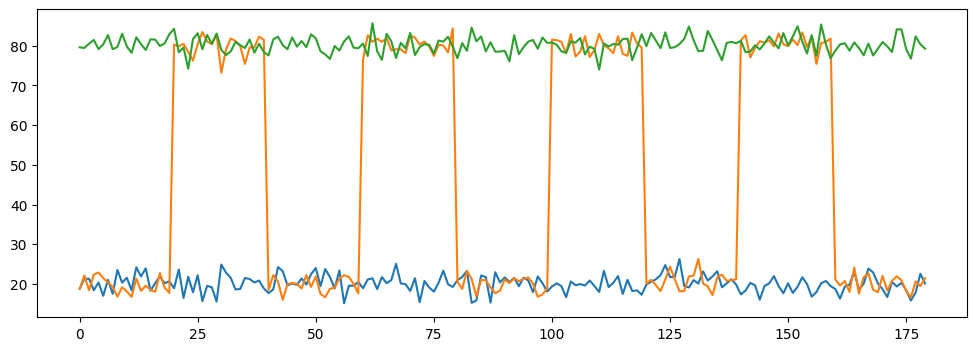

In [275]:
f, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(rew_all)

### compare how different are model predictions

In [254]:
chdf =  pd.DataFrame()
N=180
iterations = 20

for ii in range(iterations):
    print(np.round(ii/iterations,2))
    # Generate data
    rew_all, options_all = gen_bandits(N, nbandit=3)
    #indata = {"options": repeated_df, "r":rewards, "nbandit":3, "model":rw6_val_choice, "generate_choices":1} 

    for m_idx, (m, mname) in enumerate(zip(models, model_names)): # loop over model GENERATING the data
        params_in = gen_rand_vals(bounds[mname])
        indata = {"options": options_all, "r":rew_all, "nbandit":3, "model":m, "generate_choices":1} 

        mpred = m(params_in, indata)
        chdf = pd.concat([chdf, pd.DataFrame({"dataset_id":ii,"choices": mpred["choices"].astype(int), "model": mname, "noise":noise, "noise_included": False})])

        #induce noice by randomly replaceing proportion of choices
        for noise in [0, 0.2, 0.5, 0.8]:
            mpred["choices"] = replace_random_values(mpred["choices"], indata["options"], noise)
            chdf = pd.concat([chdf, pd.DataFrame({"dataset_id":ii,"choices": mpred["choices"].astype(int), "model": mname, "noise":str(noise), "noise_included": True})])

chdf.to_csv(os.path.join(rf, "data", "choices_simulated.csv"))

0.0
0.05
0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5
0.55
0.6
0.65
0.7
0.75
0.8
0.85
0.9
0.95


In [256]:
chdf["trial"] = chdf.index

In [257]:

chdf2 = chdf.loc[chdf["noise_included"]==True,].pivot(values=["choices"], index=["dataset_id", "trial"], columns=["model", "noise"]).reset_index()

In [264]:
import seaborn as sns 
cdf = chdf2.corr().reset_index()
cdf.columns = [' '.join(col).strip() for col in cdf.columns.values]
cdf = cdf.loc[cdf["level_0"]=="choices", ] 
cdf["joint_y"] = cdf["model"] + cdf["noise"]
cdf = cdf.drop(columns=["level_0", "model", "noise", "dataset_id", "trial"]).set_index("joint_y")


<AxesSubplot: ylabel='joint_y'>

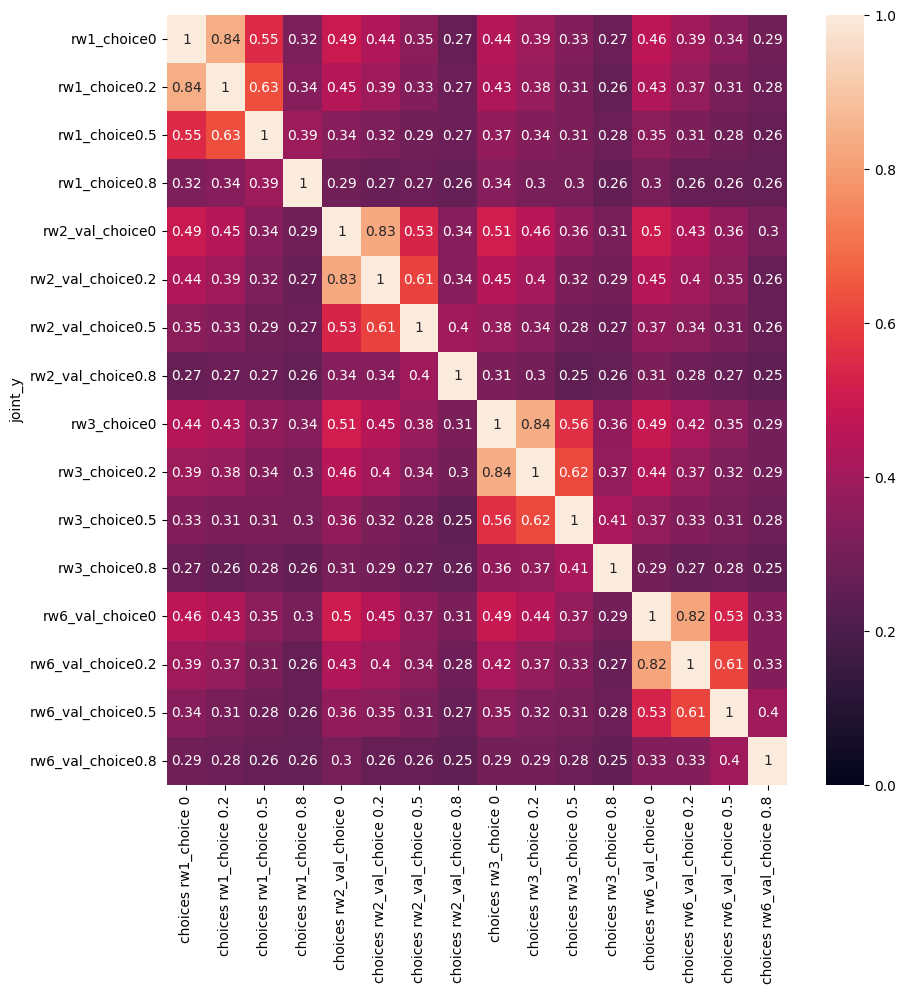

In [270]:
f,ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(cdf, vmin=0, vmax=1, annot=True, ax=ax)